In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString , Polygon, mapping, shape

import csv
from pathlib import Path

import rasterio
import rasterio.mask
from rasterio.plot import show_hist
from rasterio.plot import show

import rasterstats
from rasterstats import zonal_stats

from descartes import PolygonPatch

import geojson

from fiona import collection
import fiona

import geoplot 

from shape_generator import select_raster_file

## Setting up the data files

In [2]:
# reading in the cyclone data
data_folder = Path.cwd().parent.parent.joinpath('datasets') 
#print(data_folder)
#input_filename = 'epac-atl.csv'
#input_filename = 'ibtrax.csv'
input_filename = 'ibtrax_.csv'
#input_filename = 'missing (1).csv'
input_file = Path(data_folder).joinpath(input_filename)
print(input_file)

G:\Omdena\wfpdisrel\#task1-datacollection\datasets\ibtrax_.csv


In [3]:
# reading in the Gridded Population of the World dataset
data_folder = Path.cwd().parent.parent.joinpath('datasets', 'Gridded Population of the World (GPW)')
#print(data_folder)
input_filename = 'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2015.tif'
input_raster_file = Path(data_folder).joinpath(input_filename)
print(input_raster_file)

G:\Omdena\wfpdisrel\#task1-datacollection\datasets\Gridded Population of the World (GPW)\gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals_2015.tif


In [4]:
# get the countries associated for the geometry boundary's
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [5]:
df_input = pd.read_csv(input_file)  

In [6]:
df_input.columns

Index(['Unnamed: 0', 'SID', 'NAME', 'SEASON', 'LON', 'LAT', 'max_34', 'max_50',
       'max_64', 'SID_1', 'SID_2', 'max_34_1', 'max_50_1', 'max_64_1'],
      dtype='object')

In [7]:
#df_input.rename(columns = {'NAME':'name', 'SEASON': 'year', 'LON': 'long', 'LAT':'lat'}, inplace = True) 
#df_input.columns

## Create list of cyclones by name and year

In [70]:
cyclones = df_input.groupby(['SID', 'NAME', 'SEASON'], as_index = False).sum()
cyclones = cyclones[['SID','NAME', 'SEASON']]
cyclones

,SID,NAME,SEASON
0,1949163N07145,DELLA,1949
1,1950241N23140,JANE,1950
2,1951224N12316,CHARLIE,1951
3,1951337N09150,AMY,1951
4,1952180N05144,EMMA,1952
...,...,...,...
795,2018349N10085,PHETHAI,2018
796,2018365N09113,PABUK,2018
797,2019068S17040,IDAI,2019
798,2019113S10051,KENNETH,2019


In [72]:
i = 0
this_name = cyclone_name = (cyclones.iloc[i]['NAME'])
this_name

'DELLA'

### Helper function for getting cyclone year and name by SID

In [11]:
def get_cyclone_name_year_by_SID(SID):
    cyc_name = cyclones.loc[cyclones.SID == SID].NAME.values[0]
    cyc_year = cyclones.loc[cyclones.SID == SID].SEASON.values[0]
    return cyc_name, cyc_year    

In [12]:
#cyclone_name = 'IVAN'
#cyclone_year = 2004
SID = '2004247N10332'

In [13]:
cyclone_name, cyclone_year = get_cyclone_name_year_by_SID(SID)
print (cyclone_name, cyclone_year)

IVAN 2004


## Population extraction for a single cyclone - step by step

In [14]:
windspeeds = ['max_34','max_50', 'max_64']
windspeed = 'max_50'

### Create a dataset for a single cyclone

In [15]:
cyclone_df = df_input[(df_input.SID == SID)].copy()
cyclone_df

,Unnamed: 0,SID,NAME,SEASON,LON,LAT,max_34,max_50,max_64,SID_1,SID_2,max_34_1,max_50_1,max_64_1
39408,378376,2004247N10332,IVAN,2004,-27.60,9.70,50.0,25.0,20.0,2004247N10332,2004247N10332,50.0,25.0,20.0
39409,378377,2004247N10332,IVAN,2004,-28.11,9.70,50.0,25.0,20.0,2004247N10332,2004247N10332,50.0,25.0,20.0
39410,378378,2004247N10332,IVAN,2004,-28.70,9.70,50.0,25.0,20.0,2004247N10332,2004247N10332,50.0,25.0,20.0
39411,378379,2004247N10332,IVAN,2004,-29.45,9.71,50.0,25.0,20.0,2004247N10332,2004247N10332,50.0,25.0,20.0
39412,378380,2004247N10332,IVAN,2004,-30.30,9.70,50.0,25.0,20.0,2004247N10332,2004247N10332,50.0,25.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39581,378549,2004247N10332,IVAN,2004,-92.70,29.20,50.0,20.0,45.0,2004247N10332,2004247N10332,50.0,20.0,45.0
39582,378550,2004247N10332,IVAN,2004,-92.87,29.37,50.0,20.0,45.0,2004247N10332,2004247N10332,50.0,20.0,45.0
39583,378551,2004247N10332,IVAN,2004,-93.20,29.60,50.0,20.0,45.0,2004247N10332,2004247N10332,50.0,20.0,45.0
39584,378552,2004247N10332,IVAN,2004,-93.60,29.80,50.0,20.0,45.0,2004247N10332,2004247N10332,50.0,20.0,45.0


In [16]:
def create_shifted_dataset(df):
    my_cyclone = df[['SID', 'NAME','SEASON','LAT','LON', 'max_34', 'max_50', 'max_64']].copy()
    my_cyclone['LAT_1']= my_cyclone['LAT'].shift(-1)
    my_cyclone['LON_1']= my_cyclone['LON'].shift(-1)
    my_cyclone = my_cyclone.dropna()
    return my_cyclone

In [17]:
single_cyclone_df= create_shifted_dataset(cyclone_df)
single_cyclone_df

,SID,NAME,SEASON,LAT,LON,max_34,max_50,max_64,LAT_1,LON_1
39408,2004247N10332,IVAN,2004,9.70,-27.60,50.0,25.0,20.0,9.70,-28.11
39409,2004247N10332,IVAN,2004,9.70,-28.11,50.0,25.0,20.0,9.70,-28.70
39410,2004247N10332,IVAN,2004,9.70,-28.70,50.0,25.0,20.0,9.71,-29.45
39411,2004247N10332,IVAN,2004,9.71,-29.45,50.0,25.0,20.0,9.70,-30.30
39412,2004247N10332,IVAN,2004,9.70,-30.30,50.0,25.0,20.0,9.62,-31.21
...,...,...,...,...,...,...,...,...,...,...
39580,2004247N10332,IVAN,2004,29.09,-92.50,55.0,20.0,45.0,29.20,-92.70
39581,2004247N10332,IVAN,2004,29.20,-92.70,50.0,20.0,45.0,29.37,-92.87
39582,2004247N10332,IVAN,2004,29.37,-92.87,50.0,20.0,45.0,29.60,-93.20
39583,2004247N10332,IVAN,2004,29.60,-93.20,50.0,20.0,45.0,29.80,-93.60


In [18]:
def create_cyclone_gdf(df):
    df['point_0'] = df.apply(lambda row: Point(row.LON, row.LAT), axis=1)
    gdf = gpd.GeoDataFrame(df, geometry='point_0') #, crs={'init': 'epsg:4326'})  # deprecated version
    gdf.crs =  "EPSG:4326"
    gdf['point_1']  = gdf.apply(lambda row: Point(row.LON_1, row.LAT_1), axis=1)
    gdf['line']  = gdf.apply(lambda row: LineString((row["point_0"], row["point_1"])), axis=1)
    return gdf

### Create GeoPandasDataFrame for single cyclone

In [19]:
cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
cyclone_gdf

,SID,NAME,SEASON,LAT,LON,max_34,max_50,max_64,LAT_1,LON_1,point_0,point_1,line
39408,2004247N10332,IVAN,2004,9.70,-27.60,50.0,25.0,20.0,9.70,-28.11,POINT (-27.60000 9.70000),POINT (-28.11 9.699999999999999),"LINESTRING (-27.6 9.699999999999999, -28.11 9...."
39409,2004247N10332,IVAN,2004,9.70,-28.11,50.0,25.0,20.0,9.70,-28.70,POINT (-28.11000 9.70000),POINT (-28.7 9.699999999999999),"LINESTRING (-28.11 9.699999999999999, -28.7 9...."
39410,2004247N10332,IVAN,2004,9.70,-28.70,50.0,25.0,20.0,9.71,-29.45,POINT (-28.70000 9.70000),POINT (-29.45 9.710000000000001),"LINESTRING (-28.7 9.699999999999999, -29.45 9...."
39411,2004247N10332,IVAN,2004,9.71,-29.45,50.0,25.0,20.0,9.70,-30.30,POINT (-29.45000 9.71000),POINT (-30.3 9.699999999999999),"LINESTRING (-29.45 9.710000000000001, -30.3 9...."
39412,2004247N10332,IVAN,2004,9.70,-30.30,50.0,25.0,20.0,9.62,-31.21,POINT (-30.30000 9.70000),POINT (-31.21 9.619999999999999),"LINESTRING (-30.3 9.699999999999999, -31.21 9...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39580,2004247N10332,IVAN,2004,29.09,-92.50,55.0,20.0,45.0,29.20,-92.70,POINT (-92.50000 29.09000),POINT (-92.7 29.2),"LINESTRING (-92.5 29.09, -92.7 29.2)"
39581,2004247N10332,IVAN,2004,29.20,-92.70,50.0,20.0,45.0,29.37,-92.87,POINT (-92.70000 29.20000),POINT (-92.87 29.37),"LINESTRING (-92.7 29.2, -92.87 29.37)"
39582,2004247N10332,IVAN,2004,29.37,-92.87,50.0,20.0,45.0,29.60,-93.20,POINT (-92.87000 29.37000),POINT (-93.2 29.6),"LINESTRING (-92.87 29.37, -93.2 29.6)"
39583,2004247N10332,IVAN,2004,29.60,-93.20,50.0,20.0,45.0,29.80,-93.60,POINT (-93.20000 29.60000),POINT (-93.59999999999999 29.8),"LINESTRING (-93.2 29.6, -93.59999999999999 29.8)"


### Some helper functions for plotting

In [20]:
def plot_cyclone_on_worldmap(gdf):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    fig, ax = plt.subplots(figsize=(15, 15))
    world.plot(ax=ax, color="#cccccc")
    gdf.plot(ax=ax, markersize=1, color="#cc0000")
    plt.show()

In [21]:
def plot_cyclone_on_partial_worldmap(gdf):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    xmin, ymin, xmax, ymax = gdf.total_bounds
    partial_world= world.cx[xmin:xmax, ymin:ymax]
 
    fig, ax = plt.subplots()
    #fig, ax = plt.subplots(figsize=(10, 10))
    partial_world.plot(ax=ax, color="#cccccc")
    gdf.plot(ax=ax, markersize=1, color="#cc0000")
    plt.show()

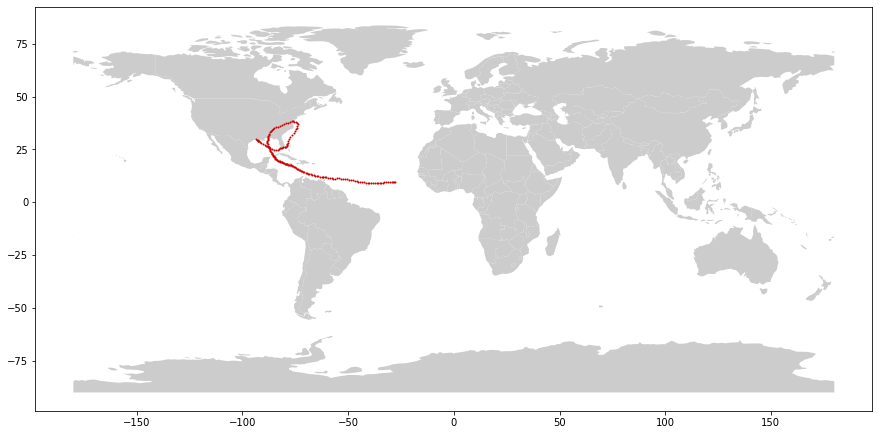

In [22]:
plot_cyclone_on_worldmap(cyclone_gdf)

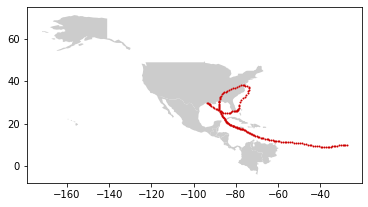

In [23]:
plot_cyclone_on_partial_worldmap(cyclone_gdf)

### Create a buffer of the GeoPandasDataFrame according to the radii of the given windspeed

In [24]:
def bufer_max_output(df,wind_speed):
    df = df.set_geometry('point_0')
    df = df.to_crs('epsg:3395')
    buffer_fact = 1825          # dimensions are in nautic miles, buffering is done in meters
    df['buf_center_{}'.format(wind_speed)] = df.apply(lambda x: x.point_0.buffer(x[wind_speed] * buffer_fact) , axis=1)
    df = df.set_geometry('buf_center_{}'.format(wind_speed))
    df = df.to_crs('epsg:4326')
    df = df.set_geometry('line')
    df = df.to_crs('epsg:3395')
    df['buf_line_{}'.format(wind_speed)] = df.apply(lambda x: x.line.buffer(x[wind_speed] * buffer_fact) , axis=1)
    df = df.set_geometry('buf_line_{}'.format(wind_speed))
    df = df.to_crs('epsg:4326')
    df = gpd.GeoDataFrame(df, geometry='buf_line_{}'.format(wind_speed))
    df.crs = 'epsg:4326'                      
    return df

### Create the outline of the shape for the given windspeed

In [25]:
def create_buffered_shape(buffer_gdf, wind_speed):
    # requires buffer_gdf that was buffered to the according windspeed!
    buffer_gdf.set_geometry('buf_center_{}'.format(wind_speed), inplace=True)
    center_shape = buffer_gdf['buf_center_{}'.format(wind_speed)].unary_union
    buffer_gdf.set_geometry('buf_line_{}'.format(wind_speed), inplace=True)
    line_shape = buffer_gdf['buf_line_{}'.format(wind_speed)].unary_union
    outline = line_shape.union(center_shape)  # combine buffered center and buffered line
    shape_gdf = GeoDataFrame( geometry = [outline])
    return shape_gdf

In [26]:
buffer_gdf = bufer_max_output(cyclone_gdf,'max_34')
buffer_gdf.tail()

,SID,NAME,SEASON,LAT,LON,max_34,max_50,max_64,LAT_1,LON_1,point_0,point_1,line,buf_center_max_34,buf_line_max_34
39580,2004247N10332,IVAN,2004,29.09,-92.50,55.0,20.0,45.0,29.20,-92.70,POINT (-10297052.898 3366336.176),POINT (-92.7 29.2),"LINESTRING (-10297052.898 3366336.176, -103193...","POLYGON ((-91.59832 29.09000, -91.60266 29.012...","POLYGON ((-93.17872 28.52736, -93.25131 28.572..."
39581,2004247N10332,IVAN,2004,29.20,-92.70,50.0,20.0,45.0,29.37,-92.87,POINT (-10319316.797 3380284.718),POINT (-92.87 29.37),"LINESTRING (-10319316.797 3380284.718, -103382...","POLYGON ((-91.88029 29.20000, -91.88423 29.129...","POLYGON ((-93.48639 28.89557, -93.53638 28.951..."
39582,2004247N10332,IVAN,2004,29.37,-92.87,50.0,20.0,45.0,29.60,-93.20,POINT (-10338241.110 3401871.342),POINT (-93.2 29.6),"LINESTRING (-10338241.110 3401871.342, -103749...","POLYGON ((-92.05029 29.37000, -92.05423 29.299...","POLYGON ((-93.71074 29.03812, -93.77113 29.084..."
39583,2004247N10332,IVAN,2004,29.60,-93.20,50.0,20.0,45.0,29.80,-93.60,POINT (-10374976.542 3431134.839),POINT (-93.59999999999999 29.8),"LINESTRING (-10374976.542 3431134.839, -104195...","POLYGON ((-92.38029 29.60000, -92.38423 29.529...","POLYGON ((-94.00738 29.17768, -94.07514 29.215..."
39584,2004247N10332,IVAN,2004,29.80,-93.60,50.0,20.0,45.0,29.89,-93.78,POINT (-10419504.338 3456636.189),POINT (-93.78 29.89),"LINESTRING (-10419504.338 3456636.189, -104395...","POLYGON ((-92.78029 29.80000, -92.78423 29.729...","POLYGON ((-94.18782 29.26846, -94.25556 29.306..."


In [27]:
max_34_shape = create_buffered_shape(buffer_gdf, 'max_34')
max_34_shape

,geometry
0,"POLYGON ((-38.23833 7.26664, -38.24756 7.26731..."


In [28]:
max_50_gdf = bufer_max_output(cyclone_gdf,'max_50')
max_50_shape = create_buffered_shape(max_50_gdf, 'max_50')
max_50_shape

,geometry
0,"POLYGON ((-37.33019 8.47228, -37.37040 8.47329..."


In [29]:
max_64_gdf = bufer_max_output(cyclone_gdf,'max_64')
max_64_shape = create_buffered_shape(max_64_gdf, 'max_64')
max_64_shape

,geometry
0,"POLYGON ((-38.20767 8.57388, -38.20951 8.57401..."


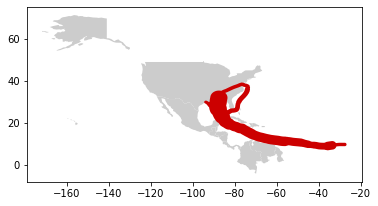

In [30]:
plot_cyclone_on_partial_worldmap(max_34_shape)

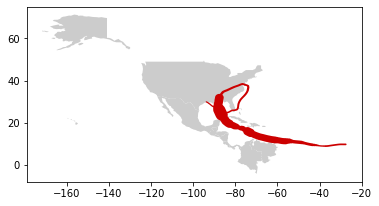

In [31]:
plot_cyclone_on_partial_worldmap(max_50_shape)

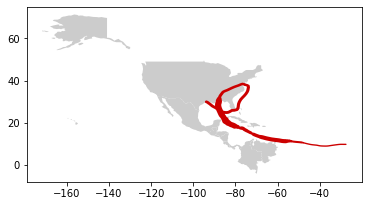

In [32]:
plot_cyclone_on_partial_worldmap(max_64_shape)

In [33]:
def get_buffered_shape(gdf, windspeed):
    buffer_gdf = bufer_max_output(gdf,windspeed)
    buffered_shape = create_buffered_shape(buffer_gdf, windspeed)
    return buffered_shape

In [34]:
shape = get_buffered_shape(cyclone_gdf, 'max_34')
shape.crs = 'epsg:4326'
shape

,geometry
0,"POLYGON ((-38.23833 7.26664, -38.24756 7.26731..."


## Overlaying the shape of the cyclone with the shapes of the worlds
### Determine the affected countries for a cyclone depending on the windspeed shape

In [35]:
affected_countries = gpd.overlay(world, shape, how='intersection')
affected_countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-75.07120 38.76613, -75.05673 ..."
1,10646714,North America,Haiti,HTI,19340.0,"POLYGON ((-73.40957 18.21258, -73.45455 18.217..."
2,329988,North America,Bahamas,BHS,9066.0,"MULTIPOLYGON (((-77.79000 27.04000, -77.67661 ..."
3,124574795,North America,Mexico,MEX,2307000.0,"POLYGON ((-89.25174 21.33841, -88.54387 21.493..."
4,47698524,South America,Colombia,COL,688000.0,"POLYGON ((-71.99170 12.20085, -71.75409 12.437..."
5,31304016,South America,Venezuela,VEN,468600.0,"MULTIPOLYGON (((-64.79900 10.12814, -64.32948 ..."
6,2990561,North America,Jamaica,JAM,25390.0,"POLYGON ((-77.56960 18.49053, -76.89662 18.400..."
7,11147407,North America,Cuba,CUB,132900.0,"MULTIPOLYGON (((-77.46186 19.87546, -77.75548 ..."
8,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


### Get the affected population

In [84]:
def get_population_by_windspeed(cyclone_name, cyclone_year, affected_countries, windspeed):
    stats = ['sum']
    raster_file = select_raster_file(cyclone_year, input_file)
    cyclone_data = []
    for i in range (len(affected_countries)):   
        cyclone = {}
        country = affected_countries.iloc[i]['name']
        iso = affected_countries.iloc[i]['iso_a3']
        population = zonal_stats(affected_countries.iloc[i].geometry, input_raster_file, stats = stats)[0]['sum']
        cyclone['NAME'] = cyclone_name
        cyclone['SEASON'] = cyclone_year
        cyclone['COUNTRY'] = country
        cyclone['iso_a3'] = iso
        cyclone['pop_{}'.format(windspeed)] = population   
        cyclone_data.append(cyclone)
    return cyclone_data, raster_file

In [85]:
cyclone_data_windspeed, raster_year = get_population_by_windspeed(cyclone_name, cyclone_year, affected_countries, windspeed)
cyclone_data_windspeed

[{'NAME': 'GLORIA',
  'SEASON': 1957,
  'COUNTRY': 'Mozambique',
  'iso_a3': 'MOZ',
  'pop_max_34': 2467098.75},
 {'NAME': 'GLORIA',
  'SEASON': 1957,
  'COUNTRY': 'Madagascar',
  'iso_a3': 'MDG',
  'pop_max_34': 240383.375}]

In [86]:
def get_population_by_windspeed_SID(SID, affected_countries, windspeed):
    
    cyclone_name, cyclone_year = get_cyclone_name_year_by_SID(SID)
    
    stats = ['sum']
    raster_file = select_raster_file(cyclone_year, input_file)
    cyclone_data = []
    for i in range (len(affected_countries)):   
        cyclone = {}
        country = affected_countries.iloc[i]['name']
        iso = affected_countries.iloc[i]['iso_a3']
        population = zonal_stats(affected_countries.iloc[i].geometry, input_raster_file, stats = stats)[0]['sum']
        cyclone['SID']= SID
        cyclone['NAME'] = cyclone_name
        cyclone['SEASON'] = cyclone_year
        cyclone['COUNTRY'] = country
        cyclone['iso_a3'] = iso
        cyclone['pop_{}'.format(windspeed)] = population   
        cyclone_data.append(cyclone)
    return cyclone_data, raster_file

In [87]:
cyclone_data_windspeed, raster_year = get_population_by_windspeed_SID(SID, affected_countries, windspeed)
cyclone_data_windspeed

[{'SID': '1949163N07145',
  'NAME': 'DELLA',
  'SEASON': 1949,
  'COUNTRY': 'Mozambique',
  'iso_a3': 'MOZ',
  'pop_max_34': 2467098.75},
 {'SID': '1949163N07145',
  'NAME': 'DELLA',
  'SEASON': 1949,
  'COUNTRY': 'Madagascar',
  'iso_a3': 'MDG',
  'pop_max_34': 240383.375}]

### Check if we are using the correct raster file

In [88]:
raster_year

'G:\\Omdena\\wfpdisrel\\#task1-datacollection\\datasets\\Gridded Population of the World (GPW)\\gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2000_30_sec.tif'

In [91]:
# Combining the different outputs into a single dataframe
cyclone_pop_df = pd.DataFrame(cyclone_data_windspeed)
data = cyclone_pop_df.groupby(['SID','NAME','SEASON', 'COUNTRY'], as_index = False).sum()
data

,SID,NAME,SEASON,COUNTRY,pop_max_34
0,1949163N07145,DELLA,1949,Madagascar,240383.375
1,1949163N07145,DELLA,1949,Mozambique,2467098.750


## Summary of the code above for a single cyclone and a single windspeed

In [92]:
SID = '2019068S17040'
windspeed = 'max_34'
#windspeed = 'max_50'
#windspeed = 'max_64'
cyclone_df = df_input[(df_input.SID == SID)].copy()
single_cyclone_df= create_shifted_dataset(cyclone_df)
cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
shape = get_buffered_shape(cyclone_gdf, windspeed)
shape.crs = 'epsg:4326'
affected_countries = gpd.overlay(world, shape, how='intersection')
cyclone_data_windspeed, raster_year = get_population_by_windspeed_SID(SID, affected_countries, windspeed)
cyclone_data_windspeed

[{'SID': '2019068S17040',
  'NAME': 'IDAI',
  'SEASON': 2019,
  'COUNTRY': 'Mozambique',
  'iso_a3': 'MOZ',
  'pop_max_34': 2467098.75},
 {'SID': '2019068S17040',
  'NAME': 'IDAI',
  'SEASON': 2019,
  'COUNTRY': 'Madagascar',
  'iso_a3': 'MDG',
  'pop_max_34': 240383.375}]

### Creating a function to get all the information for a single cyclone

In [93]:
def get_population_by_cyclone(cylone_name, cyclone_year):    
    single_cyclone_data = []
    cyclone_df = df_input[(df_input.SEASON==cyclone_year) & (df_input.NAME == cyclone_name)].copy()
    single_cyclone_df= create_shifted_dataset(cyclone_df)
    cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
    for windspeed in windspeeds:
        shape = get_buffered_shape(cyclone_gdf, windspeed)
        shape.crs = 'epsg:4326'
        affected_countries = gpd.overlay(world, shape, how='intersection')
        cyclone_data_windspeed, raster_year = get_population_by_windspeed(cyclone_name, cyclone_year,affected_countries, windspeed)
        single_cyclone_data.extend(cyclone_data_windspeed)
        print(cyclone_data_windspeed)
    return single_cyclone_data, raster_year

In [94]:
cyclone_year = 1950
cyclone_name = 'JANE'
example_pop, raster_year = get_population_by_cyclone(cyclone_name, cyclone_year)
print(raster_year)
print(example_pop)

[{'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_34': 43343320.0}]
[{'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_50': 21380746.0}]
[{'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_64': 13972339.0}]
G:\Omdena\wfpdisrel\#task1-datacollection\datasets\Gridded Population of the World (GPW)\gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2000_30_sec.tif
[{'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_34': 43343320.0}, {'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_50': 21380746.0}, {'NAME': 'JANE', 'SEASON': 1950, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_64': 13972339.0}]


In [95]:
def get_population_by_SID(SID):    
    single_cyclone_data = []
    cyclone_df = df_input[(df_input.SID==SID)].copy()
    single_cyclone_df= create_shifted_dataset(cyclone_df)
    cyclone_gdf = create_cyclone_gdf(single_cyclone_df)
    for windspeed in windspeeds:
        shape = get_buffered_shape(cyclone_gdf, windspeed)
        shape.crs = 'epsg:4326'
        affected_countries = gpd.overlay(world, shape, how='intersection')
        cyclone_data_windspeed, raster_year = get_population_by_windspeed_SID(SID,affected_countries, windspeed)
        single_cyclone_data.extend(cyclone_data_windspeed)
        print(cyclone_data_windspeed)
    return single_cyclone_data, raster_year

In [96]:
SID = '1949163N07145'
example_pop, raster_year = get_population_by_SID(SID)
print(raster_year)
print(example_pop)

[{'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'South Korea', 'iso_a3': 'KOR', 'pop_max_34': 26485.90234375}, {'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_34': 16431894.0}]
[{'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_50': 7958809.0}]
[{'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_64': 4553851.0}]
G:\Omdena\wfpdisrel\#task1-datacollection\datasets\Gridded Population of the World (GPW)\gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2000_30_sec.tif
[{'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'South Korea', 'iso_a3': 'KOR', 'pop_max_34': 26485.90234375}, {'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'Japan', 'iso_a3': 'JPN', 'pop_max_34': 16431894.0}, {'SID': '1949163N07145', 'NAME': 'DELLA', 'SEASON': 1949, 'COUNTRY': 'J

## Creating population data for all cyclones by SID

In [ ]:
cyclone_data = []
error_cyclone = []
#for i in range (10):                  
for i in range (len(cyclones)):             ## Change here to get output for all cyclones
    cyclone = {}
    cyclone_SID = (cyclones.iloc[i]['SID'])
    cyclone_name = (cyclones.iloc[i]['NAME'])
    cyclone_year = (cyclones.iloc[i]['SEASON'])
    print(f'{i}/{len(cyclones)} Getting population for:{cyclone_SID}-{cyclone_name}-{cyclone_year}')
    try:
        cyclone_population, raster_year = get_population_by_SID(cyclone_SID)
        cyclone_data.extend(cyclone_population)
        print(f'Rasterfile: {raster_year}')
        print('--------------------------------------------')
    except:
        print(f'Error for cyclone {cyclone_name} - {cyclone_year}')
        error_cyclone.append((cyclone_name, cyclone_year))
cyclone_pop = pd.DataFrame(cyclone_data)
summary_df = cyclone_pop.groupby(['SID','NAME','SEASON', 'COUNTRY'], as_index = False).sum()

In [102]:
summary_df

,SID,NAME,SEASON,COUNTRY,pop_max_34,pop_max_50,pop_max_64
0,1949163N07145,DELLA,1949,Japan,1.643189e+07,7.958809e+06,4.553851e+06
1,1949163N07145,DELLA,1949,South Korea,2.648590e+04,0.000000e+00,0.000000e+00
2,1950241N23140,JANE,1950,Japan,4.334332e+07,2.138075e+07,1.397234e+07
3,1951224N12316,CHARLIE,1951,Dominican Rep.,6.813668e+02,0.000000e+00,0.000000e+00
4,1951224N12316,CHARLIE,1951,Haiti,3.154269e+05,0.000000e+00,0.000000e+00
5,1951224N12316,CHARLIE,1951,Jamaica,2.753688e+06,2.750167e+06,1.948091e+06
6,1951224N12316,CHARLIE,1951,Mexico,8.146825e+06,3.535850e+06,2.489068e+06
7,1951337N09150,AMY,1951,Philippines,1.413200e+07,8.926450e+06,3.309632e+06
8,1952180N05144,EMMA,1952,China,1.854397e+07,4.845178e+06,2.775118e+06
9,1952180N05144,EMMA,1952,Philippines,1.523273e+07,8.281656e+06,5.903694e+06


In [ ]:
summary_df.to_pickle("../data/population_by_cyclone_sm_v3.pkl")

## Check cyclones that caused geometric errors

In [ ]:
error_cyclone

### Saving the dataframe

In [ ]:
unpickled = pd.read_pickle("../data/population_by_cyclone_sm_v3.pkl")
unpickled

In [ ]:
unpickled.to_csv("../data/population_by_cyclone_sm_v3.csv")

## Creating population data for all cyclones (old version)

In [ ]:
cyclone_data = []
error_cyclone = []
for i in range (10):                  
#for i in range (len(cyclones)):             ## Change here to get output for all cyclones
    cyclone = {}
    cyclone_name = (cyclones.iloc[i]['name'])
    cyclone_year = (cyclones.iloc[i]['year'])
    print(f'{i}/{len(cyclones)} Getting population for {cyclone_name} - {cyclone_year}')
    try:
        cyclone_population, raster_year = get_population_by_cyclone(cyclone_name, cyclone_year)
        cyclone_data.extend(cyclone_population)
        print(f'Rasterfile: {raster_year}')
        print('--------------------------------------------')
    except:
        print(f'Error for cyclone {cyclone_name} - {cyclone_year}')
        error_cyclone.append((cyclone_name, cyclone_year))
cyclone_pop = pd.DataFrame(cyclone_data)
summary_df = cyclone_pop.groupby(['name','year', 'country'], as_index = False).sum()
summary_df